In [1]:
# Importing libraries used for the analysis
import pandas as pd
import numpy as np

import plotly.offline as pyo
import plotly.graph_objs as go

# Using latest version of statsmodel 0.9.0 (otherwise get errors during SARIMAX fit)
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error

from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
googleSheetId = '1MBWHr0e5uE6wVRzmgx1kf4AFRhemANHqj_nmnHiKLOM'
worksheetName = 'Sanitizer'
URL = 'https://docs.google.com/spreadsheets/d/{0}/gviz/tq?tqx=out:csv&sheet={1}'.format(
    googleSheetId,
    worksheetName
)

historical_data = pd.read_csv(URL)

In [3]:
historical_data

,Date,Price,Open,High,Low,Vol.,Change %
0,1/2/2017,54.03,54.09,54.18,54.01,-,0.58%
1,1/3/2017,52.33,54.20,55.24,52.11,727.79K,-3.15%
2,1/4/2017,53.26,52.49,53.43,52.15,512.64K,1.78%
3,1/5/2017,53.76,53.39,54.12,52.79,517.36K,0.94%
4,1/6/2017,53.99,53.73,54.32,53.32,528.33K,0.43%
...,...,...,...,...,...,...,...
1127,4/13/2021,60.18,59.64,60.59,59.64,349.73K,0.80%
1128,4/14/2021,63.15,60.44,63.44,60.38,419.81K,4.94%
1129,4/15/2021,63.46,62.83,63.57,62.53,243.37K,0.49%
1130,4/16/2021,63.13,63.32,63.88,62.83,87.80K,-0.52%


In [4]:

# Set Date column to datetime for time series
historical_data['Date'] = pd.to_datetime(historical_data['Date'],infer_datetime_format=True)

# Data file is sorted from most recent date to the past so sorting by date to go the other way around
historical_data = historical_data.sort_values(by='Date', ascending=True)

# Resetting the index due to the sort_value change
historical_data = historical_data.reset_index(drop = True)

# Dropping all columns except for the Closing Price
historical_data = historical_data.drop(columns=['Open', 'High', 'Low', 'Vol.', 'Change %'])

# Setting the Date as the index
historical_data = historical_data.set_index('Date')

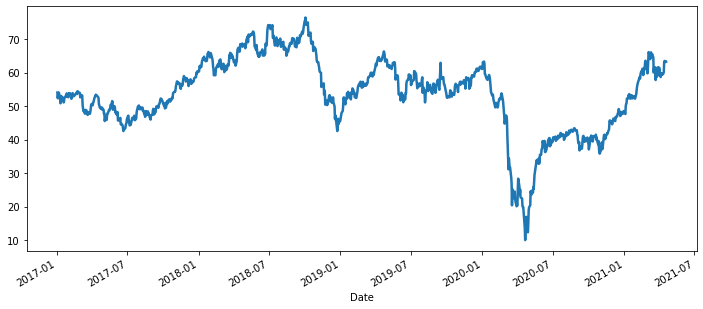

In [5]:
# Simple plot of historical data
historical_data['Price'].plot(lw=2.5, figsize=(12,5));

In [6]:
# Plotly graph of entire dataset from 1985
trace = go.Scatter(x=historical_data.index,
                       y=historical_data['Price'],
                       mode='lines')
data = [trace]

layout = go.Layout(
    title = 'West Texas Intermediate (WTI) Crude Oil Futures from 1985',
    xaxis = dict(title = 'Date'),
    yaxis = dict(title = 'Price ($)')
) 

fig = go.Figure(data = data, layout = layout)

pyo.plot(fig)

'temp-plot.html'

In [7]:
# Grabbing data from 2018-01-01
df = historical_data.loc['2018-01-01':]

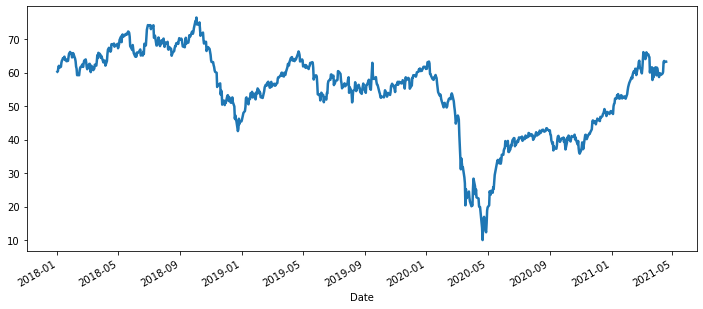

In [8]:
# Simple plot of data from January 2016
df['Price'].plot(lw=2.5, figsize=(12,5));

In [9]:
# Plotly graph of entire dataset from January 1st, 2016
trace = go.Scatter(x=df.index,
                       y=df['Price'],
                       mode='lines')
data = [trace]

layout = go.Layout(
    title = 'West Texas Intermediate (WTI) Crude Oil Futures from January, 2016',
    xaxis = dict(title = 'Date'),
    yaxis = dict(title = 'Price ($)')
) 

fig = go.Figure(data = data, layout = layout)

pyo.plot(fig)

'temp-plot.html'

Using code from How to Grid Search ARIMA Model Hyperparameters with Python, the optimal p, d, q values are found based on Mean Squared Error from doing a train-test-split on the data. They are (0, 1, 0).

# ===============================================

In [10]:
##### evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
        # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

# evaluate parameters
p_values = range(0, 4)
d_values = range(0, 4)
q_values = range(0, 4)
warnings.filterwarnings("ignore")
evaluate_models(df.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=363.276
ARIMA(0, 0, 1) MSE=101.134
ARIMA(0, 1, 0) MSE=2.468
ARIMA(0, 1, 1) MSE=2.492
ARIMA(0, 1, 2) MSE=2.502
ARIMA(0, 1, 3) MSE=2.509
ARIMA(0, 2, 0) MSE=5.023
ARIMA(0, 2, 1) MSE=2.520
ARIMA(0, 2, 2) MSE=2.557
ARIMA(0, 2, 3) MSE=2.550
ARIMA(1, 0, 0) MSE=2.476
ARIMA(1, 1, 0) MSE=2.493
ARIMA(1, 1, 3) MSE=2.509
ARIMA(1, 2, 0) MSE=3.765
ARIMA(1, 2, 1) MSE=2.534
ARIMA(1, 2, 2) MSE=2.520
ARIMA(1, 2, 3) MSE=2.531
ARIMA(2, 0, 0) MSE=2.586
ARIMA(2, 1, 0) MSE=2.502
ARIMA(2, 1, 1) MSE=3.073
ARIMA(2, 1, 2) MSE=2.524
ARIMA(2, 1, 3) MSE=2.543
ARIMA(2, 2, 0) MSE=3.371
ARIMA(2, 2, 1) MSE=2.550
ARIMA(2, 2, 2) MSE=2.570
ARIMA(3, 0, 0) MSE=2.509
ARIMA(3, 1, 0) MSE=2.510
ARIMA(3, 1, 1) MSE=2.532
ARIMA(3, 1, 3) MSE=2.541
ARIMA(3, 2, 0) MSE=3.161
ARIMA(3, 2, 1) MSE=2.566
ARIMA(3, 2, 2) MSE=2.563
Best ARIMA(0, 1, 0) MSE=2.468


In [11]:
%%time

# Instantiating the model using SARIMAX, the optimal p, d, q values, and a seasonal order based on 365 days/year.
model = sm.tsa.statespace.SARIMAX(df['Price'],
                                order=(0, 1, 0),
                                seasonal_order=(0, 1, 0, 365),
                                enforce_stationarity=True,
                                enforce_invertibility=False)

# Fitting the model
SARIMAX_results = model.fit()

Wall time: 2min 13s


In [12]:
# Getting model's predictions of the in-sample data, rounding to two decimal places for price.
SARIMAX_predictions = round(SARIMAX_results.predict(), 2)

# Creating a dataframe of the date index and predictions
SARIMAX_preds = pd.DataFrame(list(zip(list(SARIMAX_predictions.index),list(SARIMAX_predictions))),
                             columns=['Date','PredictedPrice']).set_index('Date')

# Merging the original dataframe with predictions for comparison
SARIMAX_predicted_df = pd.merge(df[1:], SARIMAX_preds, left_index=True, right_index=True)

SARIMAX_predicted_df.head()

,Price,PredictedPrice
Date,,
2018-01-02,60.37,60.24
2018-01-03,61.63,60.37
2018-01-04,62.01,61.63
2018-01-05,61.44,62.01
2018-01-08,61.73,61.44


In [13]:
print("\tMean Squared Error:", mean_squared_error(SARIMAX_predicted_df['Price'], 
                                                  SARIMAX_predicted_df['PredictedPrice']))
print("\tRoot Mean Squared Error:", np.sqrt(mean_squared_error(SARIMAX_predicted_df['Price'], 
                                                               SARIMAX_predicted_df['PredictedPrice'])))

	Mean Squared Error: 3.630711520737327
	Root Mean Squared Error: 1.9054426049444069


In [14]:
# Getting 120 days (a little more than 6 months in business days) for forecasts
SARIMAX_forecast = round(SARIMAX_results.forecast(steps = 120), 2)

# Creating an index from 2021-04-19 to six months out, frequency indicates business day which eliminates weekends and
# US holidays, then putting it all together into a SARIMAX_forecast dataframe
idx = pd.date_range('2021-04-19', '2021-10-01', freq='B')

SARIMAX_forecast = pd.DataFrame(list(zip(list(idx),list(SARIMAX_forecast))),
                             columns=['Date','ForecastPrice']).set_index('Date')

SARIMAX_forecast.head()

,ForecastPrice
Date,
2021-04-19,63.20
2021-04-20,60.29
2021-04-21,61.08
2021-04-22,61.22
2021-04-23,63.55


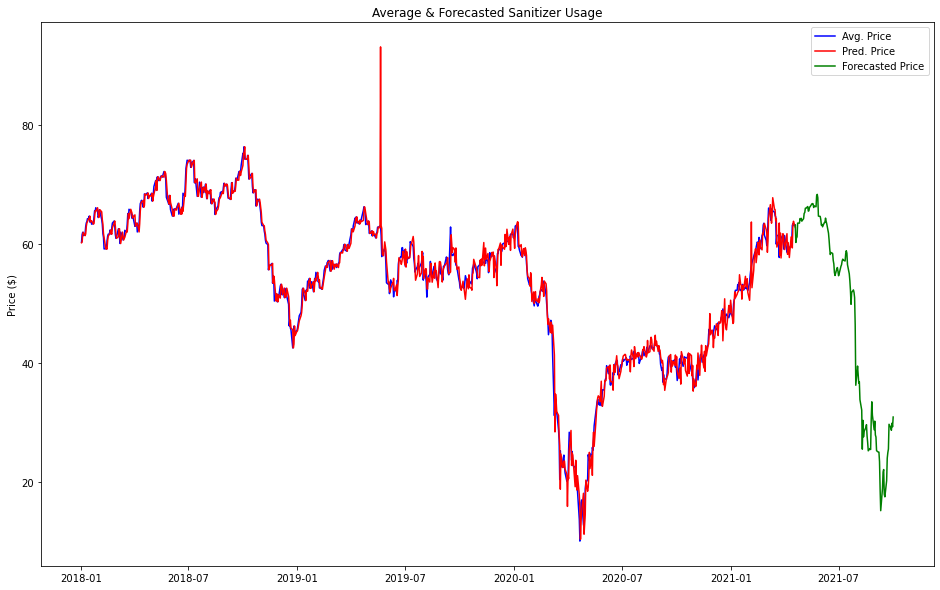

In [15]:
# Matplotlib Plot for Notebook

fig=plt.figure(figsize=[16,10])
fig.show()
ax=fig.add_subplot(111)

ax.plot(SARIMAX_predicted_df['Price'],c='b',label='Avg. Price')
ax.plot(SARIMAX_predicted_df['PredictedPrice'],c='r', label='Pred. Price')
ax.plot(SARIMAX_forecast['ForecastPrice'],c='g', label='Forecasted Price')

plt.legend(loc='best')
plt.ylabel('Price ($)')
plt.title('Average & Forecasted Sanitizer Usage')
plt.draw()

In [19]:
# Plotly Code for Blog Post
trace0 = go.Scatter(
    x = SARIMAX_predicted_df.index,
    y = SARIMAX_predicted_df['Price'],
    mode = 'lines',
    name = 'Daily Sanitizer Usage'
)
trace1 = go.Scatter(
    x = SARIMAX_predicted_df.index,
    y = SARIMAX_predicted_df['PredictedPrice'],
    mode = 'lines',
    name = 'Predicted Sanitizer Usage'
)
trace2 = go.Scatter(
    x = SARIMAX_forecast.index,
    y = SARIMAX_forecast['ForecastPrice'],
    mode = 'lines',
    name = 'Forecast Sanitizer Usage'
)
data = [trace0, trace1, trace2]

layout = go.Layout(
    title = 'SARIMAX Model: Daily & 6-Month Forecast Sanitizer Usage',
    xaxis = dict(title = 'Date'),
    yaxis = dict(title = ' Sanitizer Usage (L)')
) 

fig = go.Figure(data = data, layout = layout)

pyo.plot(fig)

'temp-plot.html'